In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow

In [ ]:
from tensorflow.random import set_seed as SEED
from tensorflow.keras import Sequential as Seq
from tensorflow.keras.losses import BinaryCrossentropy as BCE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [ ]:
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bmadushanirodrigo/fracture-multi-region-x-ray-data

Dataset URL: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data
License(s): ODC Public Domain Dedication and Licence (PDDL)
 99% 475M/481M [00:04<00:00, 110MB/s] 
100% 481M/481M [00:04<00:00, 117MB/s]


In [ ]:
import zipfile

zipref = zipfile.ZipFile('/content/fracture-multi-region-x-ray-data.zip', 'r')
zipref.extractall('Fracture_X-ray')
zipref.close()

In [ ]:
import os
count = 0

for dirpath, dirnames, filenames in os.walk('/content/Fracture_X-ray/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification'):
  print('There are {} files in {} directory {}{}'.format(len(filenames), os.path.basename(os.path.dirname(dirpath)), f"with {'directory' if len(dirnames) < 2 else 'directories'} '{os.path.basename(dirpath)}'", '\n' if count % 3 == 0 else '')) if len(filenames) > 0 else ''
  if 'train' or 'test' or 'val' in os.path.basename(os.path.dirname(dirpath)) and len(filenames) > 0:
    count += 1

There are 4606 files in train directory with directory 'fractured'
There are 4640 files in train directory with directory 'not fractured'

There are 238 files in test directory with directory 'fractured'
There are 268 files in test directory with directory 'not fractured'

There are 337 files in val directory with directory 'fractured'
There are 492 files in val directory with directory 'not fractured'



In [ ]:
import random

train_dir = '/content/Fracture_X-ray/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'
test_dir = '/content/Fracture_X-ray/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'
val_dir = '/content/Fracture_X-ray/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val'

def show_img(dir = train_dir, class_n = 0):
  dirname = os.path.join(dir, os.listdir(dir)[class_n])
  files = [os.path.join(dirname, f) for f in os.listdir(dirname)]
  random_num = random.randint(0, len(os.listdir(dirname))-1)
  img = cv2.imread(files[random_num])
  cv2.resize(img, (324, 324))
  cv2_imshow(img)

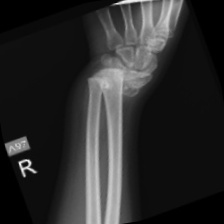

In [ ]:
show_img(train_dir, 0)

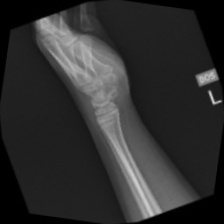

In [ ]:
show_img(train_dir, 1)

In [110]:
from PIL import Image

train_images = []
classes = []
def checking_valid_images(dir = train_dir):
  dirname = [os.path.join(dir, f) for f in os.listdir(dir)]
  files = []
  for i in dirname:
    fil = [os.path.join(i, f) for f in os.listdir(i)]
    files.append(fil)
  common_list = []
  for lists in files:
    common_list.extend(lists)
  for i in common_list:
    try:
      img = Image.open(i).convert('L')
      img_array = np.array(img, 'uint8')
      resized_image = cv2.resize(img_array, (128, 128))
      train_images.append(resized_image)
      class_name = str(i).split('/')[6]
      class_name = 1 if class_name == 'fractured' else 0
      classes.append(class_name)
    except:
      print('Skipping image')

In [111]:
checking_valid_images(train_dir)

Skipping image
Skipping image
Skipping image
Skipping image
Skipping image
Skipping image


In [112]:
len(classes)

9240

In [113]:
len(train_images)

9240

In [114]:
X = np.asarray(train_images)
y = np.asarray(classes)

In [115]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [116]:
X.shape, y.shape

((9240, 128, 128), (9240,))

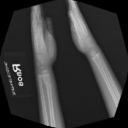

In [117]:
cv2_imshow(X[28])

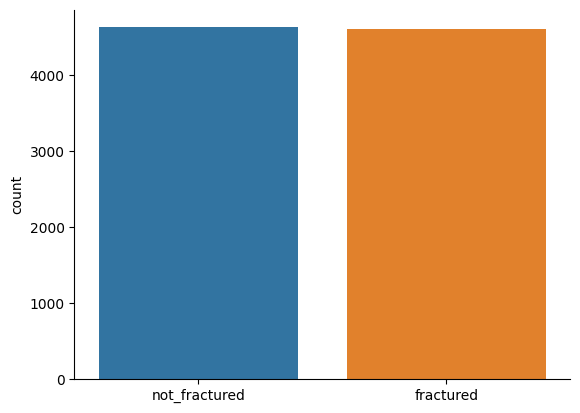

In [118]:
custom_label = ['not_fractured', 'fractured']
sns.countplot(x = y, hue = y, legend = False)
plt.xticks(ticks = [0, 1], labels = custom_label)
plt.gca().spines[['top', 'right']].set_visible(False)

In [119]:
np.unique(y, return_counts = True)

(array([0, 1]), array([4634, 4606]))

In [120]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 28)

In [121]:
train_X.shape, train_y.shape

((6930, 128, 128), (6930,))

In [122]:
test_X.shape, test_y.shape

((2310, 128, 128), (2310,))

In [123]:
len(train_X), len(train_y)

(6930, 6930)

In [124]:
len(test_X), len(test_y)

(2310, 2310)

In [125]:
len(train_X)

6930

In [127]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1/255.)

train_X = train_X.reshape(-1, 128, 128, 1)
test_X = test_X.reshape(-1, 128, 128, 1)

train_data = datagen.flow(train_X, train_y, batch_size = 32, shuffle = True)
test_data = datagen.flow(test_X, test_y, batch_size = 32, shuffle = True)

In [132]:
SEED(28)

model = Seq()
model.add(Conv2D(filters = 32,
                 kernel_size = 3,
                 strides = 1,
                 padding = 'valid',
                 input_shape = (128, 128, 1),
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = 2))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

In [133]:
model.compile(loss = BCE(),
              optimizer = Adam(),
              metrics = ['accuracy'])

In [134]:
history = model.fit(train_data,
                    epochs = 10,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = len(test_data))

Epoch 1/10
217/217 [==============================] - 7s 12ms/step - loss: 0.4441 - accuracy: 0.7978 - val_loss: 0.2991 - val_accuracy: 0.9121
Epoch 2/10
217/217 [==============================] - 2s 10ms/step - loss: 0.2366 - accuracy: 0.9260 - val_loss: 0.2091 - val_accuracy: 0.9463
Epoch 3/10
217/217 [==============================] - 3s 13ms/step - loss: 0.1598 - accuracy: 0.9569 - val_loss: 0.1719 - val_accuracy: 0.9541
Epoch 4/10
217/217 [==============================] - 2s 11ms/step - loss: 0.1101 - accuracy: 0.9758 - val_loss: 0.1247 - val_accuracy: 0.9697
Epoch 5/10
217/217 [==============================] - 2s 10ms/step - loss: 0.0772 - accuracy: 0.9828 - val_loss: 0.1075 - val_accuracy: 0.9714
Epoch 6/10
217/217 [==============================] - 2s 9ms/step - loss: 0.0585 - accuracy: 0.9883 - val_loss: 0.0911 - val_accuracy: 0.9771
Epoch 7/10
217/217 [==============================] - 2s 10ms/step - loss: 0.0459 - accuracy: 0.9929 - val_loss: 0.0817 - val_accuracy: 0.9788


In [147]:
model.evaluate(test_data)

73/73 [==============================] - 1s 16ms/step - loss: 0.0687 - accuracy: 0.9831


[0.06874009966850281, 0.983116865158081]

<Axes: >

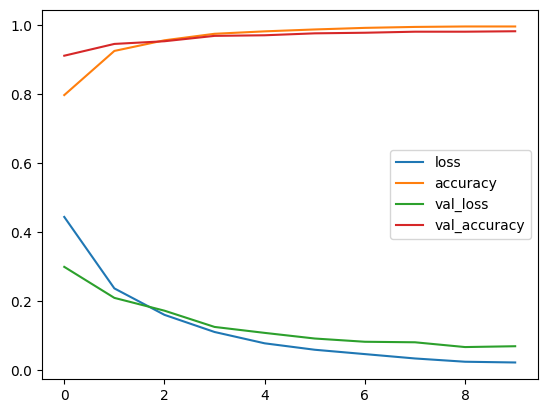

In [135]:
pd.DataFrame(history.history).plot()

In [250]:
def checking_model_acc(dir = test_dir, img_n = 1):
  dirname = [os.path.join(dir, f) for f in os.listdir(dir)]
  files = []
  for i in dirname:
    fil = [os.path.join(i, f) for f in os.listdir(i)]
    files.append(fil)
  common_list = []
  for lists in files:
    common_list.extend(lists)
  if img_n == 1:
    random_num = random.randint(0, len(common_list)-1)
    random_img = cv2.imread(common_list[random_num])
    resized_img = cv2.resize(random_img, (128, 128))
    img_array = np.array(resized_img)/255.
    resized_img_array = img_array.reshape(-1, 128, 128, 1)
    prediction = model.predict(resized_img_array)
    print(prediction)
    pred_label = 1 if prediction[2] > 0.5 else 0
    img_label = str(common_list[i]).split('/')[6]
    exp_label = 1 if img_label == 'fractured' else 0
    resized_disp = cv2.resize(random_img, (324, 324))
    cv2.putText(resized_disp, 'Pred: ' + str(pred_label), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0) if pred_label == exp_label else (0, 0, 255), 1)
    cv2.putText(resized_disp, 'Exp: ' + str(exp_label), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0), 1)
    cv2_imshow(resized_disp)
  else:
    random_num = random.sample(range(0, len(common_list)-1), img_n)
    for i in random_num:
      random_img = cv2.imread(common_list[i])
      resized_img = cv2.resize(random_img, (128, 128))
      img_array = np.array(resized_img)/255.
      resized_img_array = img_array.reshape(-1, 128, 128, 1)
      prediction = model.predict(resized_img_array)
      print(prediction)
      pred_label = 1 if prediction[2] > 0.5 else 0
      img_label = str(common_list[i]).split('/')[6]
      exp_label = 1 if img_label == 'fractured' else 0
      resized_disp = cv2.resize(random_img, (324, 324))
      cv2.putText(resized_disp, 'Pred: ' + str(pred_label), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0) if pred_label == exp_label else (0, 0, 255), 1)
      cv2.putText(resized_disp, 'Exp: ' + str(exp_label), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0), 1)
      cv2_imshow(resized_disp)

1/1 [==============================] - 0s 31ms/step
[[0.99999833]
 [0.99999976]
 [0.9999777 ]]


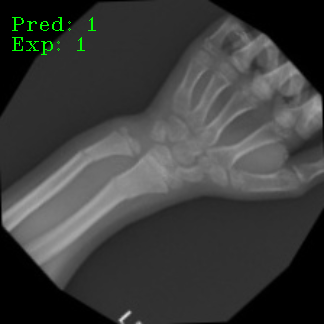

1/1 [==============================] - 0s 25ms/step
[[1.]
 [1.]
 [1.]]


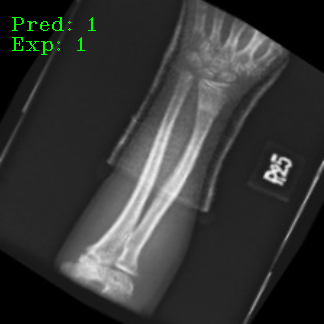

1/1 [==============================] - 0s 27ms/step
[[1.        ]
 [0.04929027]
 [0.9999999 ]]


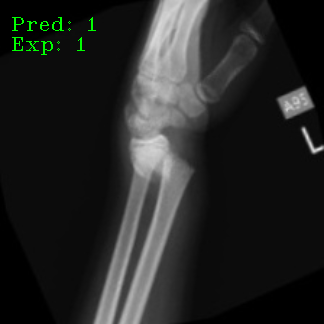

1/1 [==============================] - 0s 25ms/step
[[0.9970902]
 [0.9999821]
 [1.       ]]


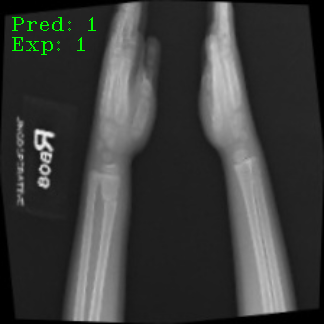

1/1 [==============================] - 0s 17ms/step
[[0.99798167]
 [0.99997663]
 [0.9996251 ]]


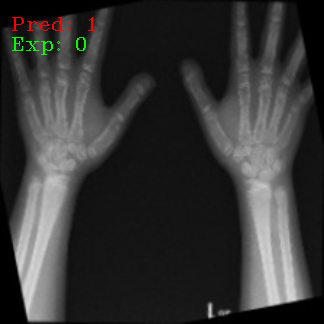

In [251]:
checking_model_acc(test_dir, 5)

In [255]:
train_images = []
classes = []
checking_valid_images(test_dir)

Skipping image
Skipping image
Skipping image
Skipping image
Skipping image
Skipping image


In [256]:
len(classes)

500

In [257]:
len(train_images)

500

In [258]:
test_dir_X = np.asarray(train_images)
test_dir_y = np.asarray(classes)

In [260]:
test_dir_X = test_dir_X.reshape(-1, 128, 128, 1)

In [263]:
prediction = model.predict(test_dir_X).astype(int)

16/16 [==============================] - 0s 4ms/step


In [269]:
prediction = np.array(prediction)

In [274]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(test_dir_y, prediction)
print(round(accuracy, 2))

0.88


<Axes: >

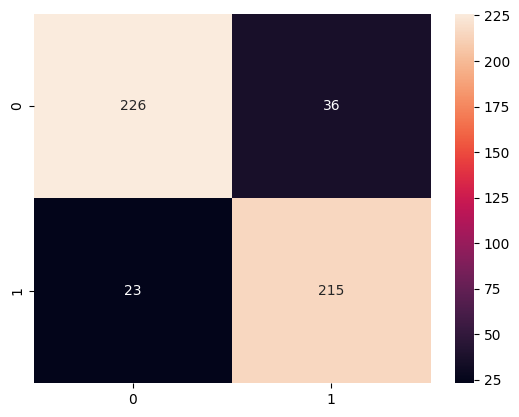

In [277]:
cm = confusion_matrix(test_dir_y, prediction)

sns.heatmap(cm, annot = True, fmt = '.0f')